In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import pickle  
import warnings
import random
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)
random.seed(42)


print("="*80)
print("GENERATING ENHANCED AGRICULTURE DATASET")
print("="*80)

def generate_enhanced_agriculture_dataset(num_samples=1000):
    """Generate a realistic, balanced agriculture dataset"""
    
    indian_states_districts = {
        'Punjab': {'districts': ['Ludhiana', 'Amritsar', 'Jalandhar', 'Patiala', 'Bathinda'], 'lat_range': (29.5, 32.0), 'long_range': (74.0, 76.5)},
        'Haryana': {'districts': ['Hisar', 'Karnal', 'Rohtak', 'Faridabad', 'Gurugram'], 'lat_range': (28.0, 30.5), 'long_range': (75.5, 77.5)},
        'Uttar Pradesh': {'districts': ['Kanpur', 'Lucknow', 'Varanasi', 'Agra', 'Meerut', 'Allahabad'], 'lat_range': (24.0, 30.5), 'long_range': (77.0, 84.0)},
        'Madhya Pradesh': {'districts': ['Bhopal', 'Indore', 'Gwalior', 'Jabalpur', 'Ujjain'], 'lat_range': (21.0, 26.5), 'long_range': (74.0, 82.5)},
        'Maharashtra': {'districts': ['Mumbai', 'Pune', 'Nagpur', 'Nashik', 'Aurangabad'], 'lat_range': (16.0, 22.0), 'long_range': (72.5, 80.5)},
        'Karnataka': {'districts': ['Bengaluru', 'Mysuru', 'Hubballi', 'Mangaluru', 'Belagavi'], 'lat_range': (12.0, 18.5), 'long_range': (74.0, 78.5)},
        'Tamil Nadu': {'districts': ['Chennai', 'Coimbatore', 'Madurai', 'Tiruchirappalli', 'Salem'], 'lat_range': (8.0, 13.5), 'long_range': (77.0, 80.5)},
        'Andhra Pradesh': {'districts': ['Visakhapatnam', 'Vijayawada', 'Guntur', 'Nellore', 'Kurnool'], 'lat_range': (13.0, 18.0), 'long_range': (77.0, 84.5)},
        'Rajasthan': {'districts': ['Jaipur', 'Jodhpur', 'Udaipur', 'Kota', 'Ajmer'], 'lat_range': (23.0, 30.0), 'long_range': (69.5, 78.0)},
        'Gujarat': {'districts': ['Ahmedabad', 'Surat', 'Vadodara', 'Rajkot', 'Bhavnagar'], 'lat_range': (20.0, 24.5), 'long_range': (68.5, 74.5)},
        'West Bengal': {'districts': ['Kolkata', 'Howrah', 'Bardhaman', 'Siliguri', 'Durgapur'], 'lat_range': (21.5, 27.0), 'long_range': (86.0, 89.0)},
        'Bihar': {'districts': ['Patna', 'Gaya', 'Bhagalpur', 'Muzaffarpur', 'Darbhanga'], 'lat_range': (24.0, 27.5), 'long_range': (83.5, 88.0)},
        'Odisha': {'districts': ['Bhubaneswar', 'Cuttack', 'Rourkela', 'Berhampur', 'Sambalpur'], 'lat_range': (17.5, 22.5), 'long_range': (81.5, 87.5)},
        'Telangana': {'districts': ['Hyderabad', 'Warangal', 'Nizamabad', 'Khammam', 'Karimnagar'], 'lat_range': (16.0, 19.5), 'long_range': (77.0, 81.0)},
        'Kerala': {'districts': ['Thiruvananthapuram', 'Kochi', 'Kozhikode', 'Kollam', 'Thrissur'], 'lat_range': (8.5, 12.5), 'long_range': (74.5, 77.5)}
    }
    
    soil_types = {
        'Alluvial': {'ph_range': (6.5, 8.0), 'fertility': 'High'},
        'Black': {'ph_range': (7.0, 8.5), 'fertility': 'Very High'},
        'Red': {'ph_range': (5.5, 7.0), 'fertility': 'Medium'},
        'Laterite': {'ph_range': (4.5, 6.5), 'fertility': 'Low'},
        'Mountain': {'ph_range': (5.0, 7.0), 'fertility': 'Medium'},
        'Sandy': {'ph_range': (7.5, 9.0), 'fertility': 'Very Low'},
        'Clay': {'ph_range': (6.0, 7.5), 'fertility': 'High'},
        'Loamy': {'ph_range': (6.0, 7.5), 'fertility': 'Medium'}
    }
    
    crops = {
        'Rice': {'duration': (90, 150), 'water_req': 'High', 'soil_pref': ['Alluvial', 'Black', 'Clay'], 
                'temp_range': (20, 35), 'rain_range': (1000, 2500), 'base_yield': (3.5, 6.5), 'base_risk': (0.1, 0.3)},
        'Wheat': {'duration': (120, 180), 'water_req': 'Medium', 'soil_pref': ['Alluvial', 'Black', 'Loamy'], 
                 'temp_range': (15, 25), 'rain_range': (500, 1000), 'base_yield': (3.0, 5.5), 'base_risk': (0.15, 0.35)},
        'Maize': {'duration': (80, 120), 'water_req': 'Medium', 'soil_pref': ['Alluvial', 'Black', 'Red'], 
                 'temp_range': (18, 30), 'rain_range': (600, 1200), 'base_yield': (4.0, 7.0), 'base_risk': (0.2, 0.4)},
        'Sugarcane': {'duration': (300, 365), 'water_req': 'Very High', 'soil_pref': ['Alluvial', 'Black'], 
                     'temp_range': (20, 35), 'rain_range': (1500, 2500), 'base_yield': (60, 100), 'base_risk': (0.25, 0.45)},
        'Cotton': {'duration': (150, 210), 'water_req': 'Low', 'soil_pref': ['Black', 'Alluvial'], 
                  'temp_range': (25, 40), 'rain_range': (500, 1000), 'base_yield': (1.5, 3.0), 'base_risk': (0.3, 0.6)},
        'Groundnut': {'duration': (90, 120), 'water_req': 'Low', 'soil_pref': ['Red', 'Sandy', 'Alluvial'], 
                     'temp_range': (25, 35), 'rain_range': (500, 1000), 'base_yield': (1.5, 2.5), 'base_risk': (0.25, 0.5)},
        'Soybean': {'duration': (90, 120), 'water_req': 'Medium', 'soil_pref': ['Black', 'Alluvial'], 
                   'temp_range': (20, 30), 'rain_range': (600, 1000), 'base_yield': (2.0, 3.5), 'base_risk': (0.2, 0.45)},
        'Mustard': {'duration': (100, 140), 'water_req': 'Low', 'soil_pref': ['Alluvial', 'Sandy'], 
                   'temp_range': (10, 25), 'rain_range': (400, 800), 'base_yield': (1.0, 2.0), 'base_risk': (0.15, 0.35)},
        'Potato': {'duration': (80, 120), 'water_req': 'Medium', 'soil_pref': ['Sandy', 'Alluvial'], 
                  'temp_range': (15, 25), 'rain_range': (500, 1000), 'base_yield': (20, 35), 'base_risk': (0.2, 0.4)},
        'Tomato': {'duration': (90, 120), 'water_req': 'Medium', 'soil_pref': ['Alluvial', 'Sandy'], 
                  'temp_range': (20, 30), 'rain_range': (600, 1000), 'base_yield': (25, 50), 'base_risk': (0.3, 0.6)},
        'Onion': {'duration': (120, 150), 'water_req': 'Medium', 'soil_pref': ['Sandy', 'Alluvial'], 
                 'temp_range': (15, 25), 'rain_range': (500, 800), 'base_yield': (15, 25), 'base_risk': (0.2, 0.4)},
        'Chilli': {'duration': (120, 150), 'water_req': 'Medium', 'soil_pref': ['Red', 'Black', 'Alluvial'], 
                  'temp_range': (20, 30), 'rain_range': (600, 1000), 'base_yield': (1.5, 3.0), 'base_risk': (0.25, 0.5)},
        'Brinjal': {'duration': (120, 150), 'water_req': 'Medium', 'soil_pref': ['Alluvial', 'Sandy'], 
                   'temp_range': (20, 30), 'rain_range': (600, 1000), 'base_yield': (20, 35), 'base_risk': (0.2, 0.4)},
        'Cabbage': {'duration': (80, 120), 'water_req': 'High', 'soil_pref': ['Alluvial', 'Sandy'], 
                   'temp_range': (15, 25), 'rain_range': (500, 1000), 'base_yield': (20, 35), 'base_risk': (0.15, 0.35)},
        'Cauliflower': {'duration': (80, 120), 'water_req': 'High', 'soil_pref': ['Alluvial', 'Sandy'], 
                       'temp_range': (15, 25), 'rain_range': (500, 1000), 'base_yield': (15, 25), 'base_risk': (0.2, 0.4)}
    }
    
    seasons = ['Kharif', 'Rabi', 'Zaid']
    data = []
    
    # Ensure balanced crop distribution
    samples_per_crop = num_samples // len(crops)
    remaining = num_samples % len(crops)
    
    for crop_idx, (crop_name, crop_info) in enumerate(crops.items()):
        crop_samples = samples_per_crop + (1 if crop_idx < remaining else 0)
        
        for _ in range(crop_samples):
            # Select state and district
            state = random.choice(list(indian_states_districts.keys()))
            district = random.choice(indian_states_districts[state]['districts'])
            
            # Generate coordinates
            lat_range = indian_states_districts[state]['lat_range']
            long_range = indian_states_districts[state]['long_range']
            latitude = round(random.uniform(*lat_range), 4)
            longitude = round(random.uniform(*long_range), 4)
            
            # Select soil type (70% chance for preferred soil)
            soil_pref = crop_info['soil_pref']
            if random.random() < 0.7 and soil_pref:
                soil_type = random.choice(soil_pref)
            else:
                soil_type = random.choice(list(soil_types.keys()))
            
            # Soil parameters
            soil_info = soil_types[soil_type]
            soil_ph = round(random.uniform(*soil_info['ph_range']), 1)
            soil_n = random.randint(20, 80)
            soil_p = random.randint(10, 60)
            soil_k = random.randint(15, 70)
            
            # Season and climate
            season = random.choice(seasons)
            
            if season == 'Kharif':
                avg_temp = random.randint(25, 35)
                rainfall = random.randint(800, 2000)
                humidity = random.randint(70, 95)
            elif season == 'Rabi':
                avg_temp = random.randint(15, 25)
                rainfall = random.randint(200, 600)
                humidity = random.randint(40, 70)
            else:  # Zaid
                avg_temp = random.randint(30, 40)
                rainfall = random.randint(100, 400)
                humidity = random.randint(30, 60)
            
            # Adjust for latitude
            if latitude < 20:  # South
                avg_temp += random.randint(2, 5)
            elif latitude > 25:  # North
                avg_temp -= random.randint(2, 5)
            
            # Soil moisture based on soil type and rainfall
            base_moisture = rainfall / 50
            if soil_type in ['Black', 'Clay']:
                soil_moisture = min(80, int(base_moisture * 1.2))
            elif soil_type in ['Sandy', 'Red']:
                soil_moisture = min(60, int(base_moisture * 0.8))
            else:
                soil_moisture = min(70, int(base_moisture))
            
            soil_moisture = max(20, soil_moisture)
            
            # Crop parameters
            crop_duration = random.randint(*crop_info['duration'])
            
            # Previous crop (avoid same crop)
            possible_previous = [c for c in crops.keys() if c != crop_name] + ['Fallow']
            previous_crop = random.choice(possible_previous)
            
            # Calculate yield with realistic factors
            base_yield = random.uniform(*crop_info['base_yield'])
            yield_modifier = 1.0
            
            # Soil fertility effect
            fertility = soil_info['fertility']
            if fertility == 'Very High':
                yield_modifier *= 1.2
            elif fertility == 'High':
                yield_modifier *= 1.1
            elif fertility == 'Low':
                yield_modifier *= 0.9
            elif fertility == 'Very Low':
                yield_modifier *= 0.8
            
            # pH effect
            if 6.0 <= soil_ph <= 7.0:
                yield_modifier *= 1.1
            elif soil_ph < 5.0 or soil_ph > 8.0:
                yield_modifier *= 0.8
            
            # Nutrient effect
            nutrient_score = (soil_n/80 + soil_p/60 + soil_k/70) / 3
            yield_modifier *= (0.8 + 0.4 * nutrient_score)
            
            # Temperature effect
            optimal_temp = crop_info['temp_range']
            temp_diff = abs(avg_temp - np.mean(optimal_temp))
            if temp_diff < 5:
                yield_modifier *= 1.0
            elif temp_diff < 10:
                yield_modifier *= 0.9
            else:
                yield_modifier *= 0.7
            
            # Rainfall effect
            optimal_rain = crop_info['rain_range']
            if optimal_rain[0] <= rainfall <= optimal_rain[1]:
                yield_modifier *= 1.1
            elif rainfall < optimal_rain[0]:
                yield_modifier *= (0.7 + 0.3 * (rainfall / optimal_rain[0]))
            else:
                yield_modifier *= (1.2 - 0.2 * ((rainfall - optimal_rain[1]) / 1000))
            
            # Final yield calculation
            final_yield = round(base_yield * yield_modifier, 2)
            
            # Calculate risk score
            base_risk = random.uniform(*crop_info['base_risk'])
            risk_modifier = 1.0
            
            # Water requirement risk
            water_req = crop_info['water_req']
            if water_req == 'High' and soil_moisture < 40:
                risk_modifier *= 1.3
            elif water_req == 'Low' and soil_moisture > 70:
                risk_modifier *= 1.2
            
            # Extreme temperature risk
            if avg_temp < optimal_temp[0] - 5 or avg_temp > optimal_temp[1] + 5:
                risk_modifier *= 1.4
            
            # Extreme rainfall risk
            if rainfall < optimal_rain[0] * 0.7 or rainfall > optimal_rain[1] * 1.3:
                risk_modifier *= 1.3
            
            # Soil pH risk
            if soil_ph < 5.5 or soil_ph > 8.0:
                risk_modifier *= 1.2
            
            final_risk = round(base_risk * risk_modifier, 3)
            final_risk = min(max(final_risk, 0.1), 0.8)
            
            # Add noise
            final_yield += random.uniform(-0.15, 0.15)
            final_yield = round(max(final_yield, 0.5), 2)
            
            data.append({
                'district': district,
                'state': state,
                'latitude': latitude,
                'longitude': longitude,
                'soil_type': soil_type,
                'soil_n': soil_n,
                'soil_p': soil_p,
                'soil_k': soil_k,
                'soil_ph': soil_ph,
                'soil_moisture': soil_moisture,
                'humidity': humidity,
                'avg_temperature': avg_temp,
                'seasonal_rainfall': rainfall,
                'climate_season': season,
                'previous_crop': previous_crop,
                'crop_name': crop_name,
                'crop_duration_days': crop_duration,
                'crop_water_requirement': crop_info['water_req'],
                'yield_tonnes_per_hectare': final_yield,
                'risk_score': final_risk
            })
    
    df = pd.DataFrame(data)
    return df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle


GENERATING ENHANCED AGRICULTURE DATASET


In [3]:

# Generate dataset
print("\nGenerating enhanced agriculture dataset...")
df = generate_enhanced_agriculture_dataset(1000)



Generating enhanced agriculture dataset...


In [4]:
# Save dataset
dataset_path = 'enhanced_agriculture_dataset.csv'
df.to_csv(dataset_path, index=False)
print(f"✅ Dataset saved: {dataset_path}")
print(f"📊 Dataset shape: {df.shape}")


✅ Dataset saved: enhanced_agriculture_dataset.csv
📊 Dataset shape: (1000, 20)



DATA ANALYSIS & VISUALIZATION

📈 BASIC STATISTICS:
Samples: 1000
Crops: 15
States: 15
Districts: 76
Soil Types: 8

📊 Yield Statistics:
Mean: 14.88
Std: 19.04
Min: 0.50
Max: 129.31

📊 Risk Statistics:
Mean: 0.461
Std: 0.154
Min: 0.148
Max: 0.800


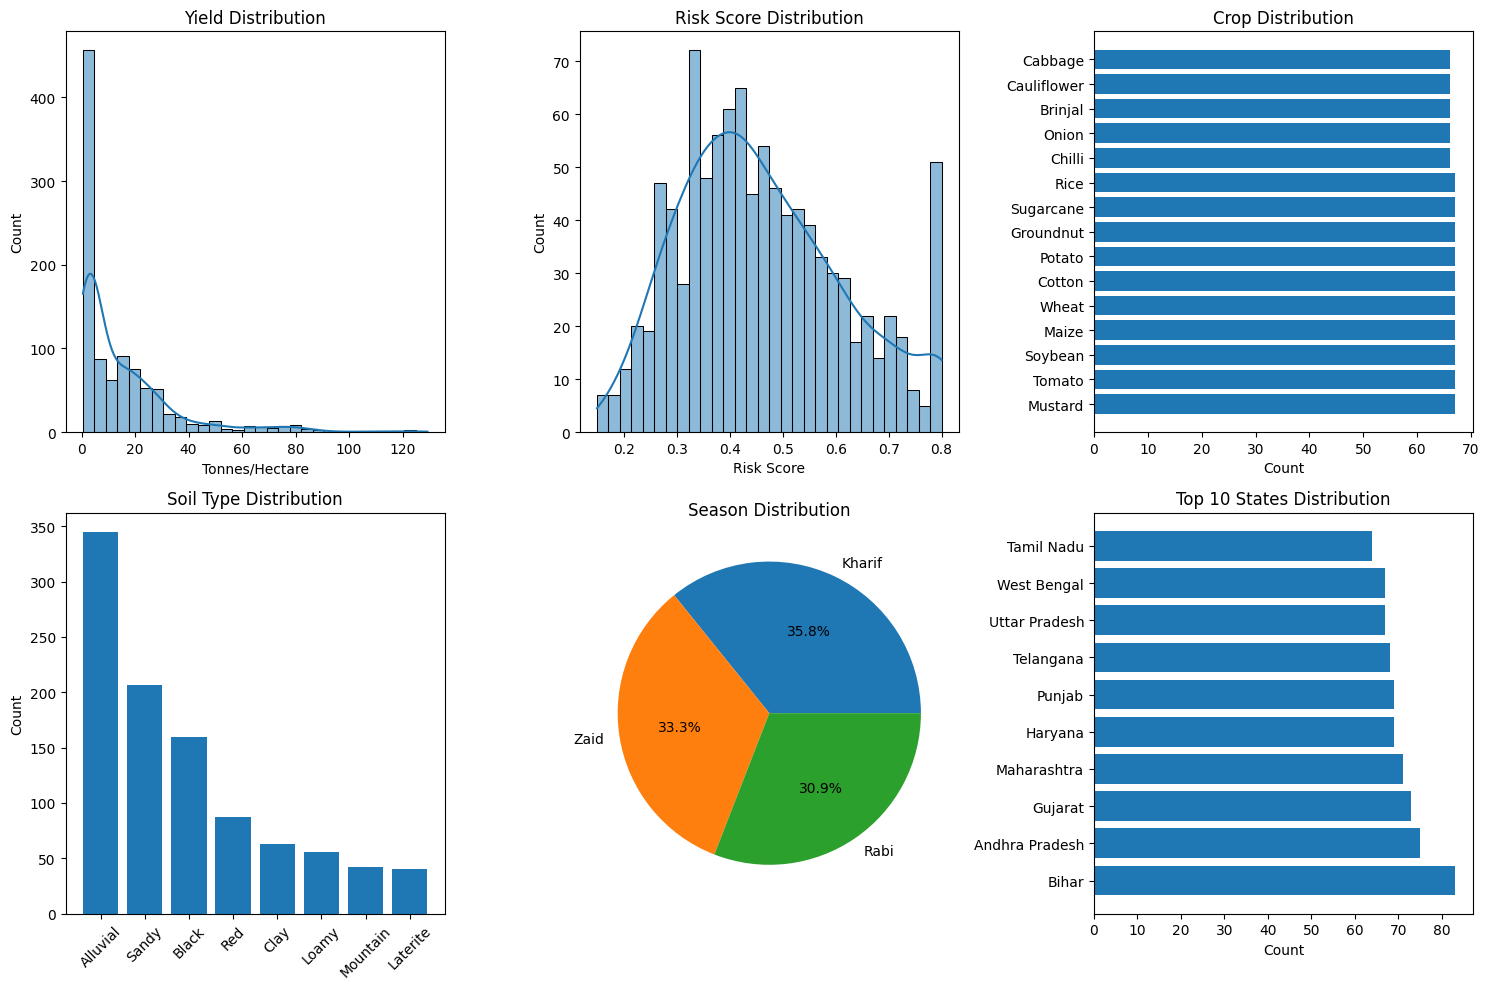

In [5]:
print("\n" + "="*80)
print("DATA ANALYSIS & VISUALIZATION")
print("="*80)

# Create visualizations directory
os.makedirs('visualizations', exist_ok=True)

# 2.1 Basic Statistics
print("\n📈 BASIC STATISTICS:")
print(f"Samples: {len(df)}")
print(f"Crops: {df['crop_name'].nunique()}")
print(f"States: {df['state'].nunique()}")
print(f"Districts: {df['district'].nunique()}")
print(f"Soil Types: {df['soil_type'].nunique()}")

print("\n📊 Yield Statistics:")
print(f"Mean: {df['yield_tonnes_per_hectare'].mean():.2f}")
print(f"Std: {df['yield_tonnes_per_hectare'].std():.2f}")
print(f"Min: {df['yield_tonnes_per_hectare'].min():.2f}")
print(f"Max: {df['yield_tonnes_per_hectare'].max():.2f}")

print("\n📊 Risk Statistics:")
print(f"Mean: {df['risk_score'].mean():.3f}")
print(f"Std: {df['risk_score'].std():.3f}")
print(f"Min: {df['risk_score'].min():.3f}")
print(f"Max: {df['risk_score'].max():.3f}")

# 2.2 Distribution Plots
plt.figure(figsize=(15, 10))

# Yield Distribution
plt.subplot(2, 3, 1)
sns.histplot(df['yield_tonnes_per_hectare'], kde=True, bins=30)
plt.title('Yield Distribution')
plt.xlabel('Tonnes/Hectare')

# Risk Distribution
plt.subplot(2, 3, 2)
sns.histplot(df['risk_score'], kde=True, bins=30)
plt.title('Risk Score Distribution')
plt.xlabel('Risk Score')

# Crop Distribution
plt.subplot(2, 3, 3)
crop_counts = df['crop_name'].value_counts()
plt.barh(range(len(crop_counts)), crop_counts.values)
plt.yticks(range(len(crop_counts)), crop_counts.index)
plt.title('Crop Distribution')
plt.xlabel('Count')

# Soil Distribution
plt.subplot(2, 3, 4)
soil_counts = df['soil_type'].value_counts()
plt.bar(range(len(soil_counts)), soil_counts.values)
plt.xticks(range(len(soil_counts)), soil_counts.index, rotation=45)
plt.title('Soil Type Distribution')
plt.ylabel('Count')

# Season Distribution
plt.subplot(2, 3, 5)
season_counts = df['climate_season'].value_counts()
plt.pie(season_counts.values, labels=season_counts.index, autopct='%1.1f%%')
plt.title('Season Distribution')

# State Distribution
plt.subplot(2, 3, 6)
state_counts = df['state'].value_counts().head(10)
plt.barh(range(len(state_counts)), state_counts.values)
plt.yticks(range(len(state_counts)), state_counts.index)
plt.title('Top 10 States Distribution')
plt.xlabel('Count')

plt.tight_layout()
plt.savefig('visualizations/distributions.png', dpi=100, bbox_inches='tight')
plt.show()


In [6]:
print("\n" + "="*80)
print("DATA PREPROCESSING")
print("="*80)

categorical_cols = ['district', 'state', 'soil_type', 'climate_season',
                   'previous_crop', 'crop_name', 'crop_water_requirement']

print("Encoding categorical variables...")
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f"  {col:25s}: {len(le.classes_):3d} unique values")

base_features = [
    'soil_n', 'soil_p', 'soil_k', 'soil_ph', 'soil_moisture',
    'humidity', 'avg_temperature', 'seasonal_rainfall',
    'crop_duration_days'
]

categorical_encoded_features = [col + '_encoded' for col in categorical_cols]
all_features = base_features + categorical_encoded_features

target_yield = 'yield_tonnes_per_hectare'
target_risk = 'risk_score'

print(f"\nTotal features: {len(all_features)}")
print(f"Base features: {len(base_features)}")
print(f"Categorical features: {len(categorical_encoded_features)}")



DATA PREPROCESSING
Encoding categorical variables...
  district                 :  76 unique values
  state                    :  15 unique values
  soil_type                :   8 unique values
  climate_season           :   3 unique values
  previous_crop            :  16 unique values
  crop_name                :  15 unique values
  crop_water_requirement   :   4 unique values

Total features: 16
Base features: 9
Categorical features: 7


In [7]:
print("\n" + "="*80)
print("MODEL TRAINING")
print("="*80)

X = df[all_features]
y_yield = df[target_yield]
y_risk = df[target_risk]

# Stratify by Crop Name (Encoded) to ensure balanced representation in Train/Test
stratify_col = df['crop_name_encoded']

print("Splitting data with stratification by Crop Name...")

X_train_y, X_test_y, y_train_y, y_test_y = train_test_split(
    X, y_yield, test_size=0.2, random_state=42, stratify=stratify_col
)

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X, y_risk, test_size=0.2, random_state=42, stratify=stratify_col
)

print(f"Training samples (Yield): {X_train_y.shape[0]}")
print(f"Test samples (Yield): {X_test_y.shape[0]}")
print(f"Training samples (Risk): {X_train_r.shape[0]}")
print(f"Test samples (Risk): {X_test_r.shape[0]}")

# Verify stratification
print("\nVerifying Split Balance (First 5 crops):")
train_counts = X_train_y['crop_name_encoded'].value_counts(normalize=True).sort_index().head()
test_counts = X_test_y['crop_name_encoded'].value_counts(normalize=True).sort_index().head()
comparison = pd.DataFrame({'Train %': train_counts, 'Test %': test_counts})
print(comparison)


MODEL TRAINING
Splitting data with stratification by Crop Name...
Training samples (Yield): 800
Test samples (Yield): 200
Training samples (Risk): 800
Test samples (Risk): 200

Verifying Split Balance (First 5 crops):
                   Train %  Test %
crop_name_encoded                 
0                  0.06625   0.065
1                  0.06625   0.065
2                  0.06625   0.065
3                  0.06625   0.065
4                  0.06750   0.065


In [8]:
print("\n🌱 TRAINING YIELD PREDICTION MODEL...")
yield_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

yield_model.fit(X_train_y, y_train_y)

yield_preds = yield_model.predict(X_test_y)
yield_mae = mean_absolute_error(y_test_y, yield_preds)
yield_rmse = np.sqrt(mean_squared_error(y_test_y, yield_preds))
yield_r2 = r2_score(y_test_y, yield_preds)
yield_mape = np.mean(np.abs((y_test_y - yield_preds) / y_test_y)) * 100

print(f"\n✅ YIELD MODEL PERFORMANCE:")
print(f"   MAE  : {yield_mae:.4f} tonnes/hectare")
print(f"   RMSE : {yield_rmse:.4f} tonnes/hectare")
print(f"   R²   : {yield_r2:.4f}")
print(f"   MAPE : {yield_mape:.2f}%")



🌱 TRAINING YIELD PREDICTION MODEL...

✅ YIELD MODEL PERFORMANCE:
   MAE  : 2.9566 tonnes/hectare
   RMSE : 5.0884 tonnes/hectare
   R²   : 0.9368
   MAPE : 34.46%


In [9]:
print("\n⚠️  TRAINING RISK PREDICTION MODEL...")
risk_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

risk_model.fit(X_train_r, y_train_r)

risk_preds = risk_model.predict(X_test_r)
risk_mae = mean_absolute_error(y_test_r, risk_preds)
risk_rmse = np.sqrt(mean_squared_error(y_test_r, risk_preds))
risk_r2 = r2_score(y_test_r, risk_preds)
risk_mape = np.mean(np.abs((y_test_r - risk_preds) / y_test_r)) * 100

print(f"\n✅ RISK MODEL PERFORMANCE:")
print(f"   MAE  : {risk_mae:.4f}")
print(f"   RMSE : {risk_rmse:.4f}")
print(f"   R²   : {risk_r2:.4f}")
print(f"   MAPE : {risk_mape:.2f}%")



⚠️  TRAINING RISK PREDICTION MODEL...

✅ RISK MODEL PERFORMANCE:
   MAE  : 0.0992
   RMSE : 0.1178
   R²   : 0.4296
   MAPE : 23.99%



MODEL EVALUATION VISUALIZATION


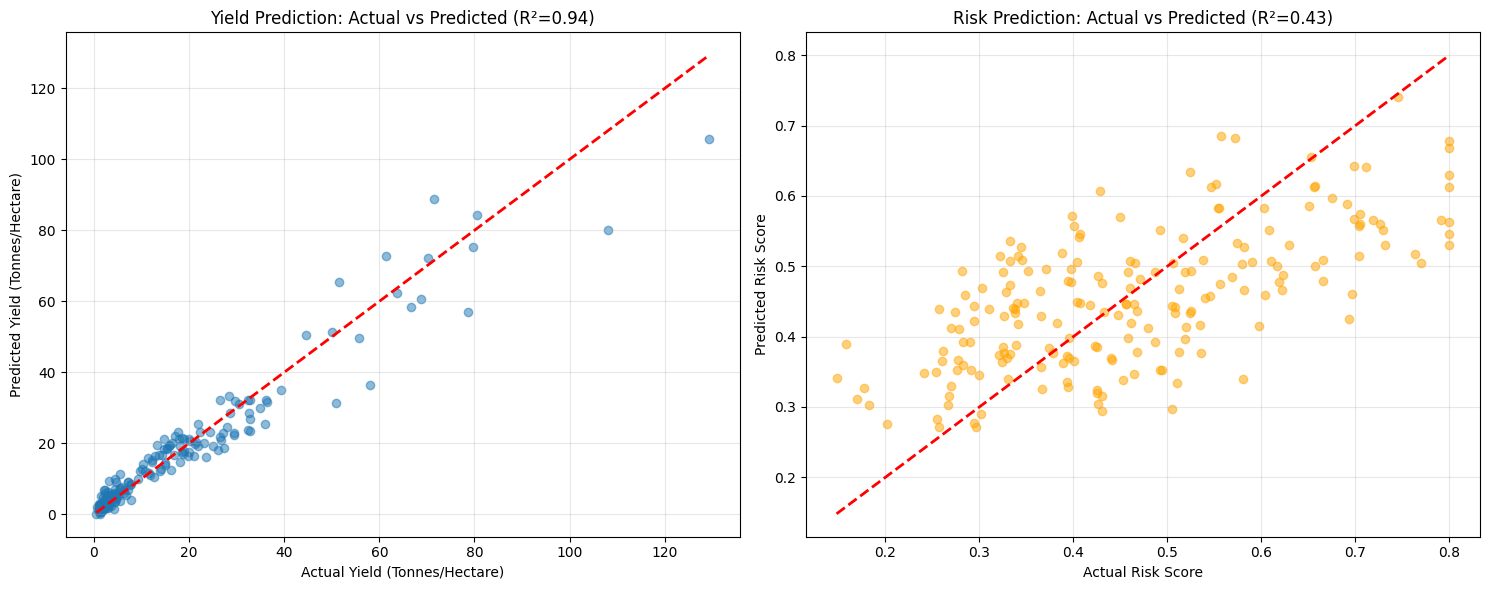

In [10]:
print("\n" + "="*80)
print("MODEL EVALUATION VISUALIZATION")
print("="*80)

plt.figure(figsize=(15, 6))

# Yield Model Evaluation
plt.subplot(1, 2, 1)
plt.scatter(y_test_y, yield_preds, alpha=0.5)
plt.plot([y_test_y.min(), y_test_y.max()], [y_test_y.min(), y_test_y.max()], 'r--', lw=2)
plt.xlabel('Actual Yield (Tonnes/Hectare)')
plt.ylabel('Predicted Yield (Tonnes/Hectare)')
plt.title(f'Yield Prediction: Actual vs Predicted (R²={yield_r2:.2f})')
plt.grid(True, alpha=0.3)

# Risk Model Evaluation
plt.subplot(1, 2, 2)
plt.scatter(y_test_r, risk_preds, alpha=0.5, color='orange')
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--', lw=2)
plt.xlabel('Actual Risk Score')
plt.ylabel('Predicted Risk Score')
plt.title(f'Risk Prediction: Actual vs Predicted (R²={risk_r2:.2f})')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/model_performance_evaluation.png', dpi=100)
plt.show()

In [11]:
print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

importance_yield = pd.DataFrame({
    'feature': all_features,
    'importance': yield_model.feature_importances_
}).sort_values('importance', ascending=False)

importance_risk = pd.DataFrame({
    'feature': all_features,
    'importance': risk_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📊 TOP 10 FEATURES FOR YIELD PREDICTION:")
print(importance_yield.head(10).to_string(index=False))

print("\n📊 TOP 10 FEATURES FOR RISK PREDICTION:")
print(importance_risk.head(10).to_string(index=False))



FEATURE IMPORTANCE ANALYSIS

📊 TOP 10 FEATURES FOR YIELD PREDICTION:
                       feature  importance
            crop_duration_days    0.378698
crop_water_requirement_encoded    0.278019
             crop_name_encoded    0.165202
        climate_season_encoded    0.041309
             soil_type_encoded    0.037742
                 soil_moisture    0.021942
             seasonal_rainfall    0.015132
               avg_temperature    0.013654
                      humidity    0.012805
                       soil_ph    0.008864

📊 TOP 10 FEATURES FOR RISK PREDICTION:
                       feature  importance
             crop_name_encoded    0.168190
crop_water_requirement_encoded    0.124473
               avg_temperature    0.117028
             seasonal_rainfall    0.083700
        climate_season_encoded    0.082397
             soil_type_encoded    0.070733
            crop_duration_days    0.052374
                       soil_ph    0.050623
                      humidity

In [12]:
print("\n" + "="*80)
print("CROP RECOMMENDATION ENGINE")
print("="*80)

class CropRecommender:
    """Crop recommendation system"""
    
    def __init__(self, yield_model, risk_model, label_encoders, all_features, df_original):
        self.yield_model = yield_model
        self.risk_model = risk_model
        self.label_encoders = label_encoders
        self.all_features = all_features
        self.df_original = df_original
        self.available_crops = label_encoders['crop_name'].classes_
        self.crop_info = self._extract_crop_info()
    
    def _extract_crop_info(self):
        """Extract information about each crop from the dataset"""
        crop_info = {}
        for crop in self.available_crops:
            crop_data = self.df_original[self.df_original['crop_name'] == crop]
            if len(crop_data) > 0:
                crop_info[crop] = {
                    'avg_yield': crop_data['yield_tonnes_per_hectare'].mean(),
                    'avg_risk': crop_data['risk_score'].mean(),
                    'avg_duration': crop_data['crop_duration_days'].mean(),
                    'water_req': crop_data['crop_water_requirement'].iloc[0]
                }
        return crop_info
    
    def prepare_input(self, input_data):
        """Prepare input data for model prediction"""
        prepared_data = input_data.copy()
        
        for col in ['district', 'state', 'soil_type', 'climate_season',
                   'previous_crop', 'crop_name', 'crop_water_requirement']:
            if col in prepared_data:
                try:
                    prepared_data[col + '_encoded'] = self.label_encoders[col].transform([prepared_data[col]])[0]
                except ValueError:
                    prepared_data[col + '_encoded'] = 0
        
        feature_vector = {}
        for feature in self.all_features:
            if feature in prepared_data:
                feature_vector[feature] = prepared_data[feature]
            elif feature.replace('_encoded', '') in prepared_data:
                orig_col = feature.replace('_encoded', '')
                feature_vector[feature] = prepared_data.get(orig_col + '_encoded', 0)
            else:
                feature_vector[feature] = self.df_original[feature].median() if feature in self.df_original.columns else 0
        
        return pd.DataFrame([feature_vector])[self.all_features]
    
    def predict_single_crop(self, environmental_data, crop_name):
        """Predict yield and risk for a specific crop"""
        input_data = environmental_data.copy()
        input_data['crop_name'] = crop_name
        
        if 'crop_water_requirement' not in input_data:
            if crop_name in self.crop_info:
                input_data['crop_water_requirement'] = self.crop_info[crop_name]['water_req']
            else:
                input_data['crop_water_requirement'] = 'Medium'
        
        X_input = self.prepare_input(input_data)
        
        predicted_yield = self.yield_model.predict(X_input)[0]
        predicted_risk = self.risk_model.predict(X_input)[0]
        
        return predicted_yield, predicted_risk
    
    def get_top_recommendations(self, environmental_data, top_n=3):
        """Get top crop recommendations with yield percentage and risk score"""
        recommendations = []
        
        for crop in self.available_crops:
            try:
                yield_pred, risk_pred = self.predict_single_crop(environmental_data, crop)
                
                avg_yield = self.crop_info[crop]['avg_yield'] if crop in self.crop_info else yield_pred
                if avg_yield > 0:
                    yield_pct = (yield_pred / avg_yield) * 100
                else:
                    yield_pct = 100
                
                # Determine risk level
                if risk_pred < 0.3:
                    risk_level = "Low"
                elif risk_pred < 0.5:
                    risk_level = "Medium"
                elif risk_pred < 0.7:
                    risk_level = "High"
                else:
                    risk_level = "Very High"
                
                score = yield_pred * (1 - risk_pred)
                
                recommendations.append({
                    'Crop': crop,
                    'Predicted Yield': yield_pred,
                    'Yield %': yield_pct,
                    'Predicted Risk': risk_pred,
                    'Risk Level': risk_level,
                    'Score': score
                })
            except Exception as e:
                print(f"Error predicting for {crop}: {e}")
                continue
        
        recommendations.sort(key=lambda x: x['Score'], reverse=True)
        
        # Format output for top N
        top_recommendations = []
        for i, rec in enumerate(recommendations[:top_n], 1):
            top_recommendations.append({
                'Rank': i,
                'Crop': rec['Crop'],
                'Yield': f"{rec['Predicted Yield']:.1f} t/ha",
                'Yield %': f"{rec['Yield %']:.0f}%",
                'Risk': f"{rec['Predicted Risk']:.2f}",
                'Risk Level': rec['Risk Level']
            })
        
        return pd.DataFrame(top_recommendations)

recommender = CropRecommender(yield_model, risk_model, label_encoders, all_features, df)

print("Crop recommendation system initialized!")
print(f"Available crops: {len(recommender.available_crops)}")



CROP RECOMMENDATION ENGINE
Crop recommendation system initialized!
Available crops: 15


In [13]:
print("\n" + "="*80)
print("SAVING MODELS & ARTIFACTS (PICKLE FORMAT)")
print("="*80)

MODEL_DIR = "crop_recommendation_models"
os.makedirs(MODEL_DIR, exist_ok=True)

with open(os.path.join(MODEL_DIR, "yield_model.pkl"), "wb") as f:
    pickle.dump(yield_model, f)

with open(os.path.join(MODEL_DIR, "risk_model.pkl"), "wb") as f:
    pickle.dump(risk_model, f)

with open(os.path.join(MODEL_DIR, "label_encoders.pkl"), "wb") as f:
    pickle.dump(label_encoders, f)

metadata = {
    'all_features': all_features,
    'base_features': base_features,
    'categorical_features': categorical_cols,
    'target_variables': [target_yield, target_risk],
    'model_performance': {
        'yield_model': {
            'mae': float(yield_mae),
            'rmse': float(yield_rmse),
            'r2': float(yield_r2),
            'mape': float(yield_mape)
        },
        'risk_model': {
            'mae': float(risk_mae),
            'rmse': float(risk_rmse),
            'r2': float(risk_r2),
            'mape': float(risk_mape)
        }
    },
    'dataset_info': {
        'total_samples': len(df),
        'num_crops': df['crop_name'].nunique(),
        'num_states': df['state'].nunique(),
        'num_districts': df['district'].nunique(),
        'generation_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }
}

# Save metadata to JSON
metadata_path = os.path.join(MODEL_DIR, "model_metadata.json")
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=4)

print(f"✅ Models saved to: {MODEL_DIR}")
print(f"✅ Metadata saved to: {metadata_path}")


SAVING MODELS & ARTIFACTS (PICKLE FORMAT)
✅ Models saved to: crop_recommendation_models
✅ Metadata saved to: crop_recommendation_models\model_metadata.json
